# DeepEyeNet-Image Captioning with key word reinforced
## Evaluation Part

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import json
import os
import re
import pickle
from tqdm import tqdm
from collections import defaultdict
import nltk
import h5py
import warnings
warnings.filterwarnings('ignore')
from nltk.translate.bleu_score import sentence_bleu

from keras.optimizers import Adam, RMSprop
from keras.models import load_model

from model.model import CaptionModel
from model.model_k import MeanModel
from utils import *

Using TensorFlow backend.


# 1. Load Data

In [2]:
# train_imgs, val_imgs, test_imgs
train_imgs = load_pickle('./data/data_path/train_imgs.pkl')
val_imgs = load_pickle('./data/data_path/val_imgs.pkl')
test_imgs = load_pickle('./data/data_path/test_imgs.pkl')

# imgs features
train_imgs_features_vgg16 = load_pickle('./data/img_features/train_imgs_features_vgg_sub.pkl')
val_imgs_features_vgg16 = load_pickle('./data/img_features/val_imgs_features_vgg_sub.pkl')
test_imgs_features_vgg16 = load_pickle('./data/img_features/test_imgs_features_vgg_sub.pkl')

train_imgs_features_vgg19 = load_pickle('./data/img_features/train_imgs_features_vgg19_sub.pkl')
val_imgs_features_vgg19 = load_pickle('./data/img_features/val_imgs_features_vgg19_sub.pkl')
test_imgs_features_vgg19 = load_pickle('./data/img_features/test_imgs_features_vgg19_sub.pkl')

train_imgs_features_inceptionV3 = load_pickle('./data/img_features/train_imgs_features_inceptionV3_sub.pkl')
val_imgs_features_inceptionV3 = load_pickle('./data/img_features/val_imgs_features_inceptionV3_sub.pkl')
test_imgs_features_inceptionV3 = load_pickle('./data/img_features/test_imgs_features_inceptionV3_sub.pkl')

# Important features
results = load_pickle('./data/data_path/results.pkl')

In [3]:
# Parameters
vocab_size = len(results['word2id'])
max_len = max([len(x) for x in results['cap_toks'].values()])
embedding_size = 300
new_vocab_size = len(results['word2id_keys'])
key_max_len = max([len(x) for x in results['keywords_ids'].values()])

param = {}

param["key_max_len"] = key_max_len
param["keywords_ids"] = results['keywords_ids']
param["embedding_size"] = embedding_size
param["vocab_size"] = new_vocab_size
param["max_len"] = max_len
param["word2id"] = results["word2id"]
param["id2word"] = results["id2word"]

In [4]:
# MODEL VGG16 (No keywords)
model_obj = CaptionModel(embedding_size, vocab_size, max_len, results['word2id'], results['id2word'], 4096)
final_model = model_obj.forward()
final_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
final_model = load_model('./checkpoints/model_vgg_new_e3.h5')

# MODEL VGG16 (With keywords)
model_obj_k = MeanModel(param, 4096)
final_model_k = model_obj_k.forward()
final_model_k.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
final_model_k = load_model('./checkpoints/model_vgg_new_keywords_e3.h5')

In [5]:
# MODEL VGG19 (No keywords)
model_obj_VGG19 = CaptionModel(embedding_size, vocab_size, max_len, results['word2id'], results['id2word'], 4096)
final_model_VGG19 = model_obj_VGG19.forward()
final_model_VGG19.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
final_model_VGG19 = load_model('./checkpoints/model_vgg19_new_e3.h5')

In [6]:
# MODEL InceptionV3 (No keywords)
model_obj_i3 = CaptionModel(embedding_size, vocab_size, max_len, results['word2id'], results['id2word'], 2048)
final_model_i3 = model_obj_i3.forward()
final_model_i3.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
final_model_i3 = load_model('./checkpoints/model_inceptionV3_new_e2.h5')

# MODEL InceptionV3 (With keywords)
model_obj_i3_k = MeanModel(param, 2048)
final_model_i3_k = model_obj_i3_k.forward()
final_model_i3_k.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
final_model_i3_k = load_model('./checkpoints/model_inceptionV3_new_keywords_e1.h5')

### Choose which model you would like to test

In [8]:
train_imgs_features = train_imgs_features_inceptionV3
test_imgs_features = test_imgs_features_inceptionV3
model_obj = model_obj_i3
final_model = final_model_i3
model_obj_k = model_obj_i3_k
final_model_k = final_model_i3_k
results_path = 'results/results_i3.pkl'
output_file = 'results/results.txt'

# 2. Evaluation

In [9]:
def predict_caption_bleu(img_id, imgs, imgs_feats, model, obj, key_flag, bs_flag):
    if key_flag:
        if bs_flag:
            predicted = text_prepare(obj.predict_captions_beam_search_k(imgs[img_id], imgs_feats, model))
        else:
            predicted = text_prepare(obj.predict_captions_k(imgs[img_id], imgs_feats, model))
    else:
        if bs_flag:
            predicted = text_prepare(obj.predict_captions_beam_search(imgs[img_id], imgs_feats, model))
        else:
            predicted = text_prepare(obj.predict_captions(imgs[img_id], imgs_feats, model))
            
    ground_truth = text_prepare(results['descriptions'][imgs[img_id]])

    # Show results
    print('Predicted Caption: {}'.format(predicted))
    print('Ground Truth Caption: {}'.format(ground_truth))

    # Bleu Score Calculation
    predicted_tok = predicted.split(" ")
    ground_truth_tok = [ground_truth.split(" ")]
    print('Bleu Score 1: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))))
    print('Bleu Score 2: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 1, 0, 0))))
    print('Bleu Score 3: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 1, 0))))
    print('Bleu Score 4: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 0, 1))))

    im = Image.open(imgs[img_id]+'.jpg')
    plt.imshow(im)
    plt.axis('off')

In [10]:
def predict_captions(imgs, imgs_feats, model, obj, key_flag, bs_flag):
    # for bleu score
    avgscore1, avgscore2, avgscore3, avgscore4 = 0,0,0,0
    # for cider, rouge
    gts, res = {}, {}
    
    for i,img in tqdm(enumerate(imgs)):
        if key_flag:
            if bs_flag:
                predicted = text_prepare(obj.predict_captions_beam_search_k(img, imgs_feats, model))
            else:
                predicted = text_prepare(obj.predict_captions_k(img, imgs_feats, model))
        else:
            if bs_flag:
                predicted = text_prepare(obj.predict_captions_beam_search(img, imgs_feats, model))
            else:
                predicted = text_prepare(obj.predict_captions(img, imgs_feats, model))
            
        ground_truth = text_prepare(results['descriptions'][img])
        
        # for bleu score
        predicted_tok = predicted.split(" ")
        ground_truth_tok = [ground_truth.split(" ")]
        avgscore1 += sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))
        avgscore2 += sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 1, 0, 0))
        avgscore3 += sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 1, 0))
        avgscore4 += sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 0, 1))
            
        # for cider, rouge
        if img not in gts:
            gts[img] = [ground_truth]
        else:
            gts[img] = [gts[img], ground_truth]
        if img not in res:
            res[img] = [predicted]
        else:
            res[img] = [res[img], predicted]
    
    avgscore = np.asarray([avgscore1,avgscore2,avgscore3,avgscore4])
    avgscore = avgscore/len(imgs)
        
    return gts, res, avgscore

In [33]:
# Run the model you would like to test
train_gts, train_res, train_avgscore = predict_captions(train_imgs, 
                                                        train_imgs_features, 
                                                        final_model, 
                                                        model_obj, 0, 0)
test_gts, test_res, test_avgscore = predict_captions(test_imgs, 
                                                     test_imgs_features, 
                                                     final_model, 
                                                     model_obj, 0, 0)
train_gts_k, train_res_k, train_avgscore_k = predict_captions(train_imgs, 
                                                              train_imgs_features, 
                                                              final_model_k, 
                                                              model_obj_k, 1, 0)
test_gts_k, test_res_k, test_avgscore_k = predict_captions(test_imgs, 
                                                           test_imgs_features, 
                                                           final_model_k, 
                                                           model_obj_k, 1, 0)

1567it [13:13,  1.97it/s]
196it [01:34,  2.49it/s]


In [34]:
pred_results = {'train_gts':train_gts,
                'train_res':train_res,
                'train_avgscore':train_avgscore,
                'test_gts':test_gts,
                'test_res':test_res,
                'test_avgscore':test_avgscore}
                'train_gts_k':train_gts_k,
                'train_res_k':train_res_k,
                'train_avgscore_k':train_avgscore_k,
                'test_gts_k':test_gts_k,
                'test_res_k':test_res_k,
                'test_avgscore_k':test_avgscore_k}

In [35]:
save_pickle(pred_results, results_path)

In [11]:
pred_results = load_pickle(results_path)
train_gts = pred_results['train_gts']
train_res = pred_results['train_res']
train_avgscore = pred_results['train_avgscore']
test_gts = pred_results['test_gts']
test_res = pred_results['test_res']
test_avgscore = pred_results['test_avgscore']
train_gts_k = pred_results['train_gts_k']
train_res_k = pred_results['train_gts_k']
train_avgscore_k = pred_results['train_avgscore_k']
test_gts_k = pred_results['test_gts_k']
test_res_k = pred_results['test_res_k']
test_avgscore_k = pred_results['test_avgscore_k']

## A. Bleu Score

In [12]:
print('-----------------')
for i in range(4):
    print("Average Bleu-{} score for original model with train imgs: {:.4f}".format(i,train_avgscore[i]))
print('-----------------')
for i in range(4):
    print("Average Bleu-{} score for original model with test imgs: {:.4f}".format(i,test_avgscore[i]))
print('-----------------')
for i in range(4):
    print("Average Bleu-{} score for keyword model with train imgs: {:.4f}".format(i,train_avgscore_k[i]))
print('-----------------')
for i in range(4):
    print("Average Bleu-{} score for keyword model with train imgs: {:.4f}".format(i,test_avgscore_k[i]))
print('-----------------')

-----------------
Average Bleu-0 score for original model with train imgs: 0.9825
Average Bleu-1 score for original model with train imgs: 0.9226
Average Bleu-2 score for original model with train imgs: 0.8182
Average Bleu-3 score for original model with train imgs: 0.7889
-----------------
Average Bleu-0 score for original model with test imgs: 0.6709
Average Bleu-1 score for original model with test imgs: 0.5910
Average Bleu-2 score for original model with test imgs: 0.4594
Average Bleu-3 score for original model with test imgs: 0.4342
-----------------
Average Bleu-0 score for keyword model with train imgs: 0.9913
Average Bleu-1 score for keyword model with train imgs: 0.9342
Average Bleu-2 score for keyword model with train imgs: 0.8345
Average Bleu-3 score for keyword model with train imgs: 0.8074
-----------------
Average Bleu-0 score for keyword model with train imgs: 0.6924
Average Bleu-1 score for keyword model with train imgs: 0.6096
Average Bleu-2 score for keyword model wit

### Single Example

No Beam Search: 
Predicted Caption: 60 year old white male. srnv md. 20/200 and 20/50.
Ground Truth Caption: 60 year old white male. srnv md. 20/200 and 20/50.
Bleu Score 1: 1.0
Bleu Score 2: 1.0
Bleu Score 3: 1.0
Bleu Score 4: 1.0
With Beam Search: 
Predicted Caption: 60 year old white male. srnv md. 20/200 and 20/50.
Ground Truth Caption: 60 year old white male. srnv md. 20/200 and 20/50.
Bleu Score 1: 1.0
Bleu Score 2: 1.0
Bleu Score 3: 1.0
Bleu Score 4: 1.0


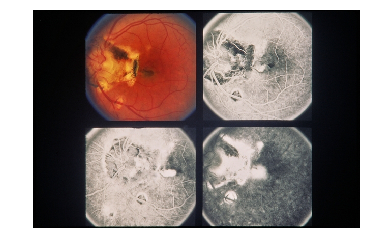

In [27]:
# Without keywords
train_id = 310
print("No Beam Search: ")
predict_caption_bleu(train_id, train_imgs, train_imgs_features, final_model, model_obj, 0, 0)
print("With Beam Search: ")
predict_caption_bleu(train_id, train_imgs, train_imgs_features, final_model, model_obj, 0, 1)

No Beam Search: 
Predicted Caption: 60 year old white male. srnv md. 20/200 and 20/50.
Ground Truth Caption: 60 year old white male. srnv md. 20/200 and 20/50.
Bleu Score 1: 1.0
Bleu Score 2: 1.0
Bleu Score 3: 1.0
Bleu Score 4: 1.0
With Beam Search: 
Predicted Caption: 60 year old white male. srnv md. 20/200 and 20/50.
Ground Truth Caption: 60 year old white male. srnv md. 20/200 and 20/50.
Bleu Score 1: 1.0
Bleu Score 2: 1.0
Bleu Score 3: 1.0
Bleu Score 4: 1.0


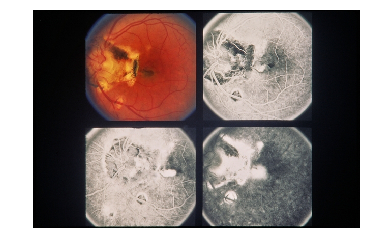

In [28]:
# Without keywords
train_id = 310
print("No Beam Search: ")
predict_caption_bleu(train_id, train_imgs, train_imgs_features, final_model_k, model_obj_k, 1, 0)
print("With Beam Search: ")
predict_caption_bleu(train_id, train_imgs, train_imgs_features, final_model_k, model_obj_k, 1, 1)

## B. Cider, Rouge

In [13]:
from eval_tools import Cider, Rouge

def calc_scores(scorer, name):
    print('-----------------------------')
    print(name+':')
    (score, scores) = scorer.compute_score(train_gts, train_res)
    print('train %s score = %.4f' % (name,score))
    (score, scores) = scorer.compute_score(test_gts, test_res)
    print('test %s score = %.4f' % (name,score))
    (score, scores) = scorer.compute_score(train_gts_k, train_res_k)
    print('train %s score (key model) = %.4f' % (name,score))
    (score, scores) = scorer.compute_score(test_gts_k, test_res_k)
    print('test %s score (key model) = %.4f' % (name,score))

In [14]:
calc_scores(Cider(), 'cider')
calc_scores(Rouge(), 'rouge')

-----------------------------
cider:
train cider score = 8.6489
test cider score = 4.5284
train cider score (key model) = 9.0316
test cider score (key model) = 4.8400
-----------------------------
rouge:
train rouge score = 0.9850
test rouge score = 0.6944
train rouge score (key model) = 1.0000
test rouge score (key model) = 0.7138


## C. Self-Defined Classifier

In [39]:
from eval_model import CLRScorer
candidate = ['diabetic retinopathy fundus image']
refs = ['diabetic retinopathy fundus image.']
scorer = CLRScorer('srnv-md')
score,label = scorer.calc_score(candidate, refs)

In [40]:
print(score)
print(label)

0.9874752759933472
['diabetic-retinopathy']


# 3. Comparison

In [15]:
for i in range(4):
    print('-----------------------------')
    print('Bleu score %s:' % str(i+1))
    print("train bleu %d score = %.4f" % (i+1,train_avgscore[i]))
    print("test bleu %d score = %.4f" % (i+1,test_avgscore[i]))
    print("train bleu %d score (key model) = %.4f" % (i+1,train_avgscore_k[i]))
    print("test bleu %d score (key model) = %.4f" % (i+1,test_avgscore_k[i]))
calc_scores(Cider(), 'cider')
calc_scores(Rouge(), 'rouge')

-----------------------------
Bleu score 1:
train bleu 1 score = 0.9825
test bleu 1 score = 0.6709
train bleu 1 score (key model) = 0.9913
test bleu 1 score (key model) = 0.6924
-----------------------------
Bleu score 2:
train bleu 2 score = 0.9226
test bleu 2 score = 0.5910
train bleu 2 score (key model) = 0.9342
test bleu 2 score (key model) = 0.6096
-----------------------------
Bleu score 3:
train bleu 3 score = 0.8182
test bleu 3 score = 0.4594
train bleu 3 score (key model) = 0.8345
test bleu 3 score (key model) = 0.4790
-----------------------------
Bleu score 4:
train bleu 4 score = 0.7889
test bleu 4 score = 0.4342
train bleu 4 score (key model) = 0.8074
test bleu 4 score (key model) = 0.4539
-----------------------------
cider:
train cider score = 8.6489
test cider score = 4.5284
train cider score (key model) = 9.0316
test cider score (key model) = 4.8400
-----------------------------
rouge:
train rouge score = 0.9850
test rouge score = 0.6944
train rouge score (key model) =

# 4. Sample Results

In [44]:
def test(idds, imgs, imgs_features, model, model_obj, train_gts, train_res):
    #Cider & Rouge
    (score, scores) = Cider().compute_score(train_gts, train_res)
    print('Cider score = %.4f' % (score))
    (score, scores) = Rouge().compute_score(train_gts, train_res)
    print('Rouge score = %.4f' % (score))
    
    for idd in idds:
        print("\n========Image Id: {}========".format(idd))
        predicted = model_obj.predict_captions(imgs[idd], imgs_features, model)
        ground_truth = results['descriptions'][imgs[idd]]
        predicted_tok = model_obj.text_prepare(predicted)
        ground_truth_tok = [model_obj.text_prepare(ground_truth)]
        
        print('Predicted Caption: {}'.format(predicted))
        print('Ground Truth Caption: {}'.format(ground_truth))

        # Bleu Score Calculation
        print('Bleu Score 1: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))))
        print('Bleu Score 2: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 1, 0, 0))))
        print('Bleu Score 3: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 1, 0))))
        print('Bleu Score 4: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 0, 1))))

In [49]:
idds = np.random.randint(0,len(train_imgs),5)
train_gts, train_res, avgscore = predict_captions(np.asarray(train_imgs)[idds], train_imgs_features_vgg16, final_model, model_obj, 0, 0)
test(idds, train_imgs, train_imgs_features_vgg16, final_model, model_obj, train_gts, train_res)

5it [00:02,  1.67it/s]


Cider score = 7.0636
Rouge score = 0.8774

========Image Id: 1248========
Predicted Caption: 68 year old white male. srnv md. re 5/200 le 20/15.
Ground Truth Caption: 68-year-old white male. srnv-md. re 5/200 le 20/15.
Bleu Score 1: 1.0
Bleu Score 2: 1.0
Bleu Score 3: 1.0
Bleu Score 4: 1.0

========Image Id: 52========
Predicted Caption: recurrent central serous retinopathy with edema.
Ground Truth Caption: recurrent central serous retinopathy with edema.
Bleu Score 1: 1.0
Bleu Score 2: 1.0
Bleu Score 3: 1.0
Bleu Score 4: 1.0

========Image Id: 900========
Predicted Caption: srnv md.
Ground Truth Caption: srnv-md.
Bleu Score 1: 1.0
Bleu Score 2: 1.0
Bleu Score 3: 1.0
Bleu Score 4: 1.0

========Image Id: 777========
Predicted Caption: 70 year old white female. srnv md/ ped. re 20/20 le 20/40.
Ground Truth Caption: 70-year-old white female. srnv-md/ ped. re 20/20 le 20/40.
Bleu Score 1: 1.0
Bleu Score 2: 1.0
Bleu Score 3: 1.0
Bleu Score 4: 1.0

========Image Id: 1413========
Predicted Ca